# Projeto 3 - Ciência dos Dados

#### Stephanie Wertheimer, Thomas Pilnik e Victor Sznifer

Nesse projeto, temos duas bases de dados: uma com dados laboratoriais a respeito quantidade de E. Coli presente na água das praias de Chicago, Illinois, e outra que mensura diferentes características físicas da água, ambas em diferentes datas e horários. Nosso objetivo é buscar uma relação entre a proliferação de bactérias e os parâmetros físicos utlizados para analisar a água. Faremos isso usando um modelo de regressão linear e analisando a correlação entre a concentração de bactérias e as diferentes variáveis físicas. 

In [1]:
#Importando diretórios

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Thomas Pilnik\Ciência dos Dados\Projeto3


Abaixo fizemos as edições necessárias em nomes das células para conseguir fazer as alterações necessárias posteriormente para relacionar informações:

In [3]:
#Abrindo bases de dados
lab = pd.read_csv('Beach_Lab_Data.csv', sep=',')
water = pd.read_csv('Beach_Water_Quality_-_Automated_Sensors.csv', sep=',')

#Editando as colunas dos Data Frames

lab.columns = ["DNATestID", "Timestamp", "Beach", "DNA1","DNA2", "DNAMean", "CultureTestID","Sample1TimeStamp","Sample1Reading","Sample2Reading","ReadingMean","CultureNote","SampleInterval","Sample2TimeStamp","Latitude","Longitude","Location"]
water.columns = ["Beach", "Timestamp", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "BatteryLife","TimestampLabel","ID"]


#Selecionando as colunas do Date Frame 
lab = pd.DataFrame(lab.loc[:, ["DNATestID", "Beach", "DNAMean","ReadingMean","Sample1TimeStamp"]])
water=pd.DataFrame(water.loc[:, ["Beach", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "TimestampLabel"]])

#Editando e padronizando o nome das praias

lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'South Shore'].index)
lab=lab.drop(lab[lab.Beach == '12th Street'].index)
lab=lab.drop(lab[lab.Beach == 'North Avenue'].index)
lab=lab.drop(lab[lab.Beach == 'Humboldt'].index)

lab['Sample1TimeStamp']=pd.to_datetime(lab.Sample1TimeStamp).dt.date

water=water.drop(water[water.Beach == 'Osterman Beach'].index)

water['Nível']='Médio'
water.loc[(water.Beach == "Montrose Beach"), "Nível"] = "Montrose"
water.loc[(water.Beach == "Calumet Beach"), "Nível"] = "Calumet"
water.loc[(water.Beach == "Ohio Street Beach"), "Nível"] = "Ohio Street"
water.loc[(water.Beach == "Rainbow Beach"), "Nível"] = "Rainbow"
water.loc[(water.Beach == "63rd Street Beach"), "Nível"] = "63rd Street"

del water['Beach']

#Padronizando data e hora do Data Frame de dados da água 

water['TimestampLabel']=pd.to_datetime(water.TimestampLabel).dt.date

Nossa base de dados teve as colunas filtradas de acordo com as variáveis que julgamos necessárias para fazer nossa análise.
No caso da base de dados de dados laboratoriais, decidimos que só era importante para nós analisar a média, e o horário. A medição que usamos para fazer as análises nesse sentido é a Reading Mean, dada em CPU.
CFU- Colony-Forming Unit

Em microbiologia, a CFU é usada para estimar o número de células de bactérias ou fungos viáveis em uma amostra. Ser viável significa ser capaz de se multiplicar por meio de fissão binária (mitose).

Já para as características físicas da água, decidimos analisar a Turbidez, Temperatura, Período da Onda, Altura da Onda, e Profundidade do Transductor. 

In [4]:
lab.head()

,DNATestID,Beach,DNAMean,ReadingMean,Sample1TimeStamp
0,NaN,NaN,NaN,239.3,2013-08-15
2,NaN,Hartigan,NaN,69.0,2010-06-02
5,NaN,Marion Mahony Griffin,NaN,7.1,2015-08-13
7,NaN,Marion Mahony Griffin,NaN,57.8,2007-08-17
8,NaN,Hartigan,NaN,10.8,2015-09-04


In [5]:
water.head()

,WtrTemperature,Turbidity,TransducerDepth,WaveHeight,WavePeriod,TimestampLabel,Nível
0,20.3,1.18,0.891,0.080,3.0,2013-08-30,Montrose
1,14.4,1.23,NaN,0.111,4.0,2016-05-26,Ohio Street
2,23.2,3.63,1.201,0.174,6.0,2013-09-03,Calumet
3,16.2,1.26,1.514,0.147,4.0,2014-05-28,Calumet
4,14.4,3.36,1.388,0.298,4.0,2014-05-28,Montrose


Para conseguir relacionar as informações das bases de dados, tivemos que usar o join. Precisávamos relacionar informações por meio de localização geográfica, ou seja, pelo nome da praia, e também pelo horário. Como precisávamos cruzar duas informações, usamos o módulo merge do pandas. 

In [6]:
#join das duas bases de dados 

joined = lab.set_index('Beach').join(water.set_index('Nível'), how='inner', lsuffix='lab', rsuffix='_water')

new_df = pd.merge(lab, water,  how='inner', left_on=['Beach','Sample1TimeStamp'], right_on = ['Nível','TimestampLabel'])

new_df.head()


,DNATestID,Beach,DNAMean,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,TransducerDepth,WaveHeight,WavePeriod,TimestampLabel,Nível
0,983.0,Rainbow,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
1,1070.0,Rainbow,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
2,1631.0,Rainbow,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
3,1567.0,Rainbow,230.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
4,1408.0,Rainbow,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow


Criamos novas bases de dados, uma para cada variável analisada, para não perder nenghuma informação da variável em questão. Depois disso plotamos gráficos de correlação para mostrar como se relaciona cada variável à ocorrência de bactérias na água.
Também calculamos valores de covariância e correlação de cada variável.

In [7]:
#Criação de novas dataframes cruzando as variáveis que vaão ser analisadas 
#Remoção dos NANs apenas para as variáveis em análise para aumentar o número de amostras relevantes para essa análise específica 
Temperatura = new_df[['ReadingMean','WtrTemperature']].dropna()
Turbidez = new_df[['ReadingMean',"Turbidity"]].dropna()
Transdutor = new_df[['ReadingMean',"TransducerDepth"]].dropna()
Altura_Onda = new_df[['ReadingMean',"WaveHeight"]].dropna()
Periodo_Onda = new_df[['ReadingMean',"WavePeriod"]].dropna()

In [8]:
print("Covariância entre ReadingMean e WaterTemperature:",Temperatura.ReadingMean.cov(Temperatura.WtrTemperature))

print("Correlação entre ReadingMean e WaterTemperature:",Temperatura.ReadingMean.corr(Temperatura.WtrTemperature))


Covariância entre ReadingMean e WaterTemperature: -73.8015378912
Correlação entre ReadingMean e WaterTemperature: -0.047056310804


In [9]:
# Regressão entre ReadingMean e WaterTemperature com ajuste linear

a = Temperatura.ReadingMean.cov(Temperatura.WtrTemperature) / Temperatura.ReadingMean.var()
b = Temperatura.WtrTemperature.mean() - a*Temperatura.ReadingMean.mean()

print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Coeficiente linear: 19.4112129038
Coeficiente angular: -0.0003604107792


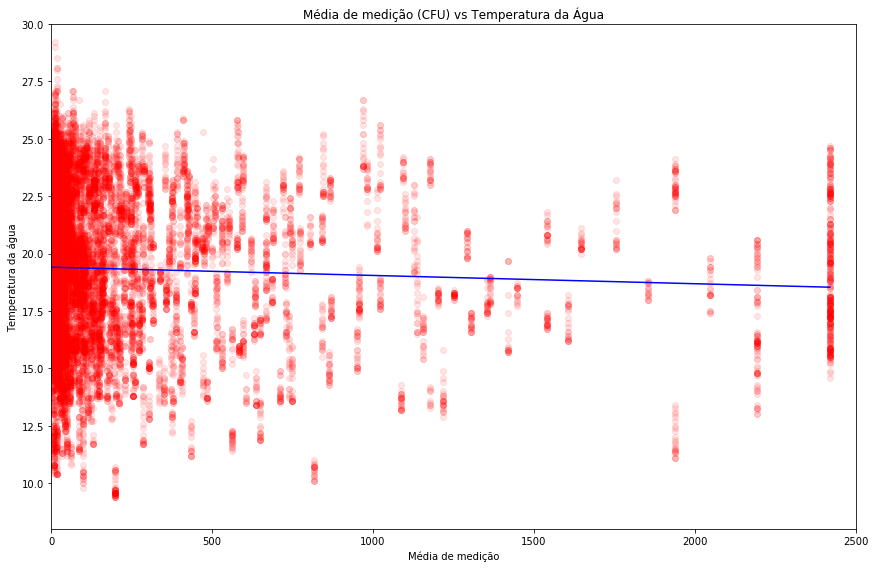

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Temperatura.ReadingMean, Temperatura.WtrTemperature, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Temperatura da Água')
plt.xlabel('Média de medição')
plt.ylabel('Temperatura da água')

plt.plot((Temperatura.ReadingMean.min(),Temperatura.ReadingMean.max()), (a*Temperatura.ReadingMean.min()+b, a*Temperatura.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,8,30])
plt.show()

In [11]:
# Regressão entre ReadingMean e Turbidez com ajuste linear

a = Turbidez.ReadingMean.cov(Turbidez.Turbidity) / Turbidez.ReadingMean.var()
b = Turbidez.Turbidity.mean() - a*Turbidez.ReadingMean.mean()

print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Coeficiente linear: 4.82831140016
Coeficiente angular: -0.00137499407935


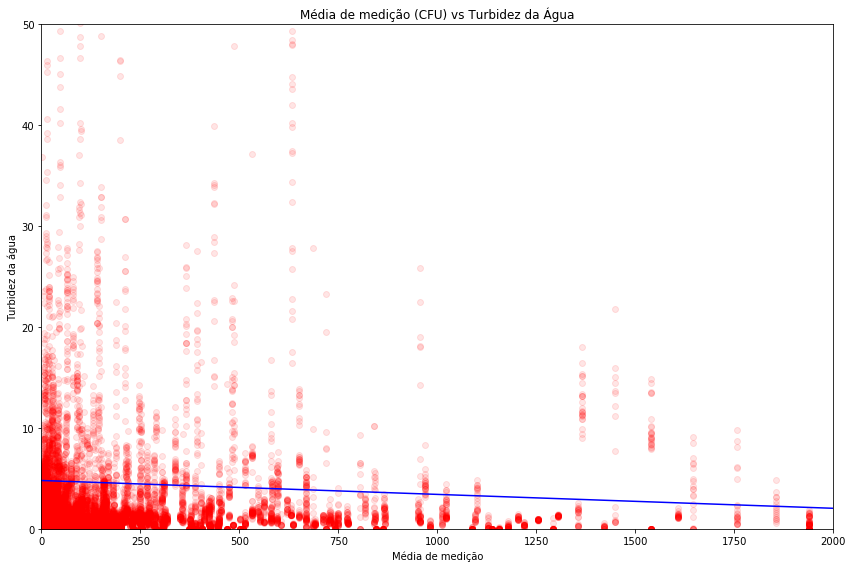

In [12]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Turbidez.ReadingMean, Turbidez.Turbidity, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Turbidez da Água')
plt.xlabel('Média de medição')
plt.ylabel('Turbidez da água')

plt.plot((Turbidez.ReadingMean.min(),Turbidez.ReadingMean.max()), (a*Turbidez.ReadingMean.min()+b, a*Turbidez.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2000,0,50])
plt.show()



In [13]:
# Regressão entre ReadingMean e profundidade do Transdutor com ajuste linear

a = Transdutor.ReadingMean.cov(Transdutor.TransducerDepth) / Transdutor.ReadingMean.var()
b = Transdutor.TransducerDepth.mean() - a*Transdutor.ReadingMean.mean()

print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Coeficiente linear: 1.61553339031
Coeficiente angular: 5.07232930544e-07


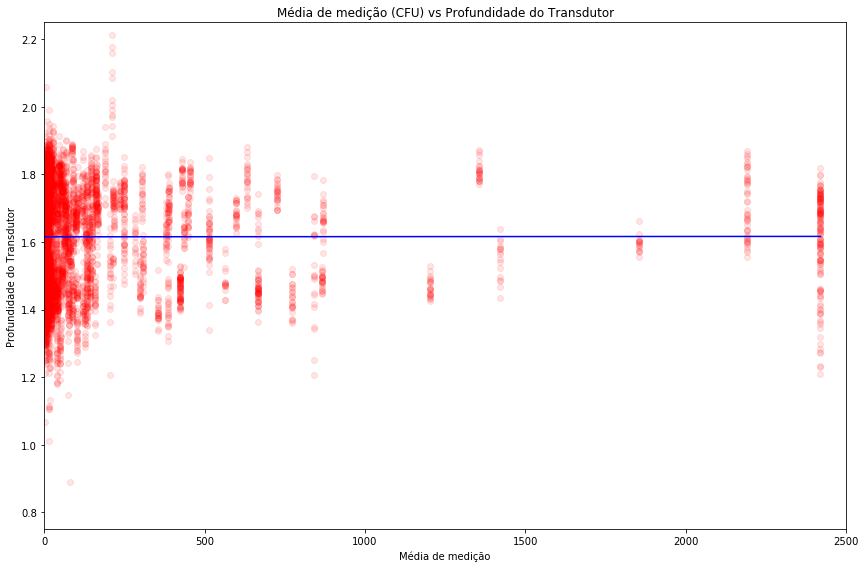

In [14]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Transdutor.ReadingMean, Transdutor.TransducerDepth, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Profundidade do Transdutor')
plt.xlabel('Média de medição')
plt.ylabel('Profundidade do Transdutor')

plt.plot((Transdutor.ReadingMean.min(),Transdutor.ReadingMean.max()), (a*Transdutor.ReadingMean.min()+b, a*Transdutor.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,0.75,2.25])
plt.show()

In [15]:
# Regressão entre ReadingMean e Altura da Onda com ajuste linear

a = Altura_Onda.ReadingMean.cov(Altura_Onda.WaveHeight) / Altura_Onda.ReadingMean.var()
b = Altura_Onda.WaveHeight.mean() - a*Altura_Onda.ReadingMean.mean()

print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Coeficiente linear: -1575.76970437
Coeficiente angular: -0.0654934610001


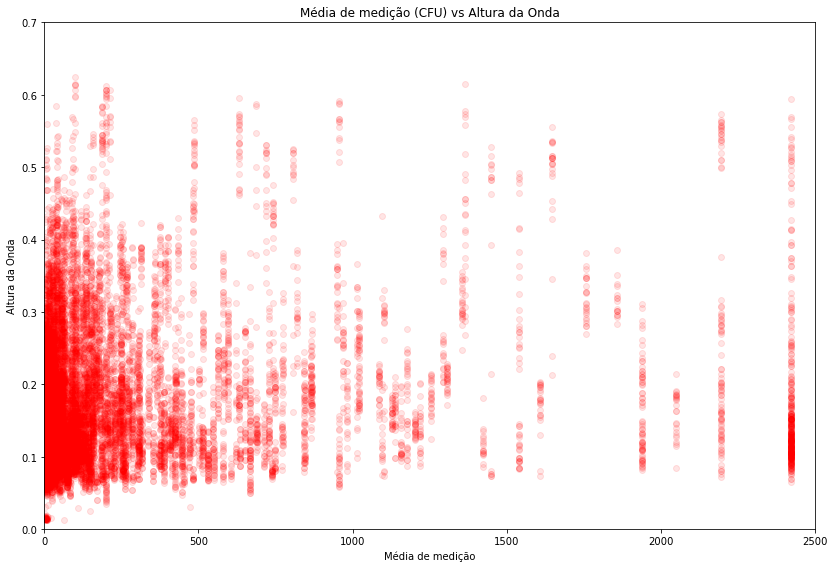

In [22]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Altura_Onda.ReadingMean, Altura_Onda.WaveHeight, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Altura da Onda')
plt.xlabel('Média de medição')
plt.ylabel('Altura da Onda')

plt.plot((Altura_Onda.ReadingMean.min(),Altura_Onda.ReadingMean.max()), (a*Altura_Onda.ReadingMean.min()+b, a*Altura_Onda.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,0,0.7])
plt.show()

In [17]:
# Regressão entre ReadingMean e Altura da Onda com ajuste linear

a = Periodo_Onda.ReadingMean.cov(Periodo_Onda.WavePeriod) / Periodo_Onda.ReadingMean.var()
b = Periodo_Onda.WavePeriod.mean() - a*Periodo_Onda.ReadingMean.mean()

print('Coeficiente linear:', b)
print('Coeficiente angular:', a)

Coeficiente linear: -1572.07160222
Coeficiente angular: -0.065256611606


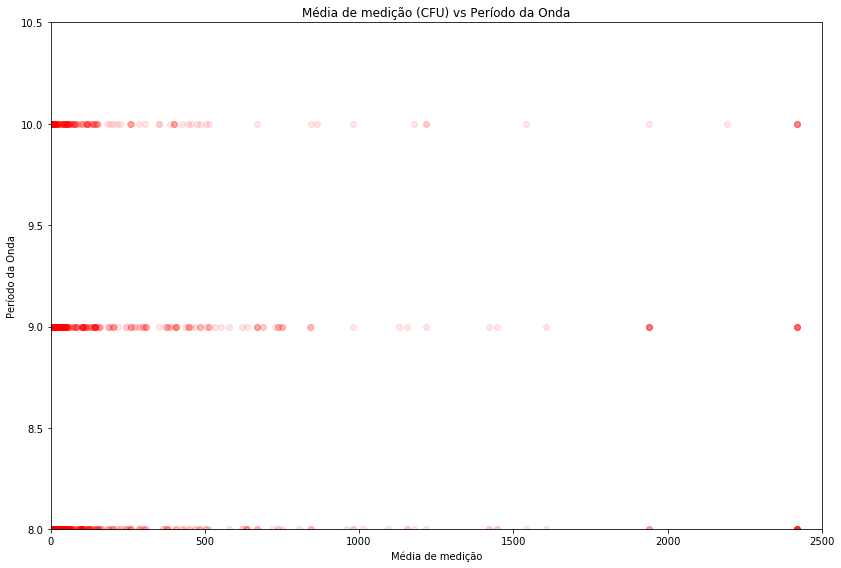

In [18]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Periodo_Onda.ReadingMean, Periodo_Onda.WavePeriod, c='red', alpha=0.1)
plt.title('Média de medição (CFU) vs Período da Onda')
plt.xlabel('Média de medição')
plt.ylabel('Período da Onda')

plt.plot((Periodo_Onda.ReadingMean.min(),Periodo_Onda.ReadingMean.max()), (a*Periodo_Onda.ReadingMean.min()+b, a*Periodo_Onda.ReadingMean.max()+b), color='blue')

plt.tight_layout()
plt.axis([0,2500,8,10.5])
plt.show()

In [24]:
xbarra = Temperatura['ReadingMean'].mean()
ybarra = Temperatura['WtrTemperature'].mean()
def sxx (lista, media):
    soma = 0
    for i in lista:
        soma += (i - media)**2
    return soma
Sxx = sxx(Temperatura['WtrTemperature'].tolist(),xbarra)

def sxy(listax, listay, mediax, mediay):
    soma = 0
    for i in range(0, len(listax)):
        soma += (listax[i] - mediax)*(listay[i] - mediay) 
    return soma
Sxy = sxy(Temperatura['WtrTemperature'].tolist(), Temperatura['ReadingMean'].tolist(), xbarra, ybarra) 

beta1 = Sxy/Sxx
beta0 = ybarra-beta1*xbarra

print("beta1:", beta1)
print('beta0:', beta0)

beta1: -1.0013938628770442
beta0: 249.48870257915323


In [26]:
xbarra = Turbidez['ReadingMean'].mean()
ybarra = Turbidez['Turbidity'].mean()
def sxx (lista, media):
    soma = 0
    for i in lista:
        soma += (i - media)**2
    return soma
Sxx = sxx(Turbidez['Turbidity'].tolist(),xbarra)

def sxy(listax, listay, mediax, mediay):
    soma = 0
    for i in range(0, len(listax)):
        soma += (listax[i] - mediax)*(listay[i] - mediay) 
    return soma
Sxy = sxy(Turbidez['Turbidity'].tolist(), Turbidez['ReadingMean'].tolist(), xbarra, ybarra) 

beta1 = Sxy/Sxx
beta0 = ybarra-beta1*xbarra

print("beta1:", beta1)
print('beta0:', beta0)

beta1: -0.9819440793850368
beta0: 230.20227180836957


In [27]:
xbarra = Transdutor['ReadingMean'].mean()
ybarra = Transdutor['TransducerDepth'].mean()
def sxx (lista, media):
    soma = 0
    for i in lista:
        soma += (i - media)**2
    return soma
Sxx = sxx(Transdutor['TransducerDepth'].tolist(),xbarra)

def sxy(listax, listay, mediax, mediay):
    soma = 0
    for i in range(0, len(listax)):
        soma += (listax[i] - mediax)*(listay[i] - mediay) 
    return soma
Sxy = sxy(Transdutor['TransducerDepth'].tolist(), Transdutor['ReadingMean'].tolist(), xbarra, ybarra) 

beta1 = Sxy/Sxx
beta0 = ybarra-beta1*xbarra

print("beta1:", beta1)
print('beta0:', beta0)

beta1: -0.9999964938314325
beta0: 198.27595968708215


In [28]:
xbarra = Altura_Onda['ReadingMean'].mean()
ybarra = Altura_Onda['WaveHeight'].mean()
def sxx (lista, media):
    soma = 0
    for i in lista:
        soma += (i - media)**2
    return soma
Sxx = sxx(Altura_Onda['WaveHeight'].tolist(),xbarra)

def sxy(listax, listay, mediax, mediay):
    soma = 0
    for i in range(0, len(listax)):
        soma += (listax[i] - mediax)*(listay[i] - mediay) 
    return soma
Sxy = sxy(Altura_Onda['WaveHeight'].tolist(), Altura_Onda['ReadingMean'].tolist(), xbarra, ybarra) 

beta1 = Sxy/Sxx
beta0 = ybarra-beta1*xbarra

print("beta1:", beta1)
print('beta0:', beta0)

beta1: -0.020821859555020025
beta0: -1586.0461975652024


In [29]:
xbarra = Periodo_Onda['ReadingMean'].mean()
ybarra = Periodo_Onda['WavePeriod'].mean()
def sxx (lista, media):
    soma = 0
    for i in lista:
        soma += (i - media)**2
    return soma
Sxx = sxx(Periodo_Onda['WavePeriod'].tolist(),xbarra)

def sxy(listax, listay, mediax, mediay):
    soma = 0
    for i in range(0, len(listax)):
        soma += (listax[i] - mediax)*(listay[i] - mediay) 
    return soma
Sxy = sxy(Periodo_Onda['WavePeriod'].tolist(), Periodo_Onda['ReadingMean'].tolist(), xbarra, ybarra) 

beta1 = Sxy/Sxx
beta0 = ybarra-beta1*xbarra

print("beta1:", beta1)
print('beta0:', beta0)

beta1: -0.020736386541030636
beta0: -1582.3132719849575


In [ ]:
residuos = []
for i in range(0, len(df['2010_income'].tolist())):
    residuos.append(df['2010_co2'].tolist()[i]-(b0+b1*df['2010_income'].tolist()[i]))